# Code Content



In [1]:
# Import base libraries for mathematical operations, dataframes, time and plotting
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import classification_report, roc_auc_score

from keras.wrappers.scikit_learn import KerasClassifier
import keras
from keras.utils import to_categorical
from keras import regularizers
from keras.constraints import maxnorm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping

from keras.layers.core import Dropout

from joblib import dump, load

Using TensorFlow backend.


In [3]:
import py_plots
from py_plots import precisionmeasures as pm

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [5]:
def performance_metrics_table(test,pred,feature):
    '''Inputs:
            test = actual labels of test set
            pred = model predictions for the the test set
            feature = feature name
            
            Computes macro- and micro- precision, recall and F1-score
        Output:
            Multi-index data frame with 3 precision measures 
    '''
    temp_dict = {'Performance':['Precision','Recall','F1-Score']}
    averages = ['micro','macro']
    for average in averages:
        p,r,f,_ = prfs(test,pred,average = average)
        temp_dict[average]= np.round((p,r,f),4)
    temp_df = pd.DataFrame(temp_dict)
    temp_df = pd.melt(temp_df, id_vars=['Performance'], value_vars=averages,
                        var_name='Metric', value_name=feature).set_index(['Metric','Performance'])
    temp_df = temp_df.rename_axis([None,'Performance Measures'])
    return temp_df

# 1. Data upload

In [6]:
class_names = ['Hate','Offensive','Neutral']
path = "datasets/balanced_dataset.csv"

In [7]:
# upload the dataset
data = pd.read_csv(path)
# drop any rows with null (after preprocessing)
data = data.dropna()
# print first 5 rows of the data set
data.head()

,labels,tweet,clean_tweet
0,0,"#sikh #temple vandalised in in #calgary, #wso ...",sikh temple vandalised in in calgary wso conde...
1,2,"@user @user @user on flipside of , praise @us...",on flipside of praise for reminder that reales...
2,2,RT @KatiePavlich: Charlie Crist doesn't have a...,charlie crist doesn t have any more political ...
3,0,@user you might be a libtard if... #libtard #...,you might be a libtard if libtard sjw liberal ...
4,0,RT @RihannaHasAids: aight game over. dykes had...,aight game over dykes had to ruin it


# 2. Split dataset into training-validation-test sets

In [8]:
# Split the dataset into training and test sets (2:1)
X_train, x_test, Y_train, y_test = train_test_split(data.clean_tweet, data.labels, test_size=0.33, random_state=42)

# maximum word count of tweets in the training set
max_length = np.max([len(tweet.split()) for tweet in X_train])

print('Maximum lenght (word-count) of tweets in the training set: {}\n'.format(max_length))


# Split the trainng dataset further into training and validation sets (2:1)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# Print
print('=='*15)
print('Training-Validation-Test Split')
print('=='*15)
print('Size of training data: {}'.format(len(y_train)))
print('..'*15)
print('Size of validation data: {}'.format(len(y_val)))
print('..'*15)
print('Size of test data: {}'.format(len(y_test)))
print('..'*15)

Maximum lenght (word-count) of tweets in the training set: 34

Training-Validation-Test Split
Size of training data: 8865
..............................
Size of validation data: 4367
..............................
Size of test data: 6518
..............................


# 2. Word vectorization

## 2.1 Tokenizaition

In [9]:
# Initializer tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.append(x_val))
vocab_size = len(tokenizer.word_index)+1
print('Total size of training (including validation set) vocabulary: {} words'.format(vocab_size))

Total size of training (including validation set) vocabulary: 18602 words


# 2.2 Zero-padding

In [10]:
sequence_train = tokenizer.texts_to_sequences(x_train)
padded_train = pad_sequences(sequence_train, maxlen=max_length, padding='post') 

sequence_val = tokenizer.texts_to_sequences(x_val)
padded_val = pad_sequences(sequence_val, maxlen=max_length, padding='post') 

sequence_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(sequence_test, maxlen=max_length, padding='post') 

In [11]:
# Upload embedding matrix for words in the vocabulary
embed_dim = 300
embedding_matrix = pd.read_pickle("model/GloVe_matrix.pkl").values
print( 'Shape of embedding matrix is {} x {}'. format(embedding_matrix.shape[0],embedding_matrix.shape[1]))

Shape of embedding matrix is 18602 x 300


# 3. Final LSTM Model

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))

model.add(SpatialDropout1D(0.4))
model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(100, return_sequences=True))

model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss',patience=2)
history = model.fit(padded_train,y_train_onehot,
                    epochs=30,
                    batch_size=128,
                    validation_data=(padded_val, y_val_onehot),
                    callbacks=[es],
                    verbose=2)
pred = model.predict(padded_test)
y_pred = np.argmax(pred,axis=1)
performance_metrics_table(y_test,y_pred,'Final LSTM Model')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 34, 300)           5580600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 34, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 34, 300)           721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 34, 100)           160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 3400)              0         
_________________________________________________________________
dense_1 (Dense)      

Final LSTM Model
      Performance Measures                  
micro Precision                       0.8696
      Recall                          0.8696
      F1-Score                        0.8696
macro Precision                       0.8697
      Recall                          0.8698
      F1-Score                        0.8696

In [13]:
y_pred_onehot = to_categorical(y_pred)
cr = classification_report(y_test_onehot, y_pred_onehot,target_names=class_names,output_dict=True)

cr['Hate'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average=None)[0]} )
cr['Offensive'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average=None)[1]} )
cr['Neutral'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average=None)[2]} )
cr['micro avg'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average='micro')})
cr['macro avg'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average='macro')})
cr['weighted avg'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average='weighted')})
cr['samples avg'].update({'roc_auc' : roc_auc_score(y_test_onehot, pred,average='samples')})

score_matrix = pd.DataFrame.from_dict(cr).T
print('=='*10, 'Final Classification Report', '=='*10)
score_matrix

==================== Final Classification Report ====================


,f1-score,precision,recall,roc_auc,support
Hate,0.829369,0.834715,0.824091,0.945567,2200.0
Offensive,0.899684,0.884103,0.915823,0.977701,2174.0
Neutral,0.879660,0.890162,0.869403,0.973887,2144.0
micro avg,0.869592,0.869592,0.869592,0.967121,6518.0
macro avg,0.869571,0.869660,0.869772,0.965719,6518.0
weighted avg,0.869364,0.869426,0.869592,0.965601,6518.0
samples avg,0.869592,0.869592,0.869592,0.924363,6518.0


Confusion matrix, without normalization
[[1813  201  186]
 [ 139 1991   44]
 [ 220   60 1864]]
Normalized confusion matrix
[[0.82409091 0.09136364 0.08454545]
 [0.06393744 0.91582337 0.02023919]
 [0.10261194 0.02798507 0.86940299]]


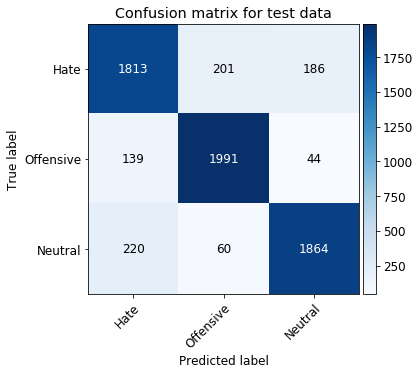

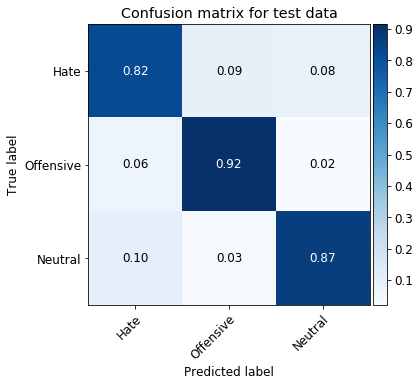

In [14]:
pm.plot_confusion_matrix(y_test.values, y_pred, classes=class_names,
                         title='Confusion matrix for test data');
pm.plot_confusion_matrix(y_test.values, y_pred, classes=class_names,normalize=True,
                         title='Confusion matrix for test data');

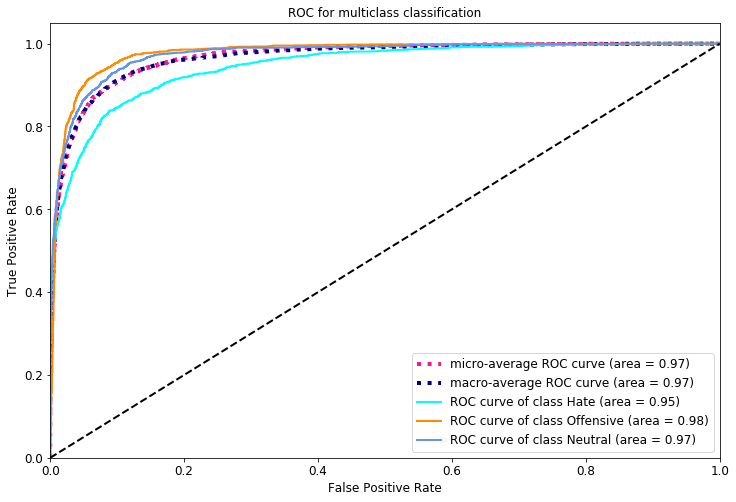

In [15]:
roc_auc = pm.ROC_curve(y_test_onehot, pred,3)